In [4]:
import glob
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

IM_WIDTH = 256
IM_HEIGHT = 256

ModuleNotFoundError: No module named 'tensorflow'

In [14]:
!pip install tensorflow-gpu=2

ModuleNotFoundError: No module named 'tensorflow'

In [5]:
train_files = []
mask_files = glob.glob('data/lgg-mri-segmentation/kaggle_3m/*/*_mask*')

for i in mask_files:
    train_files.append(i.replace('_mask',''))

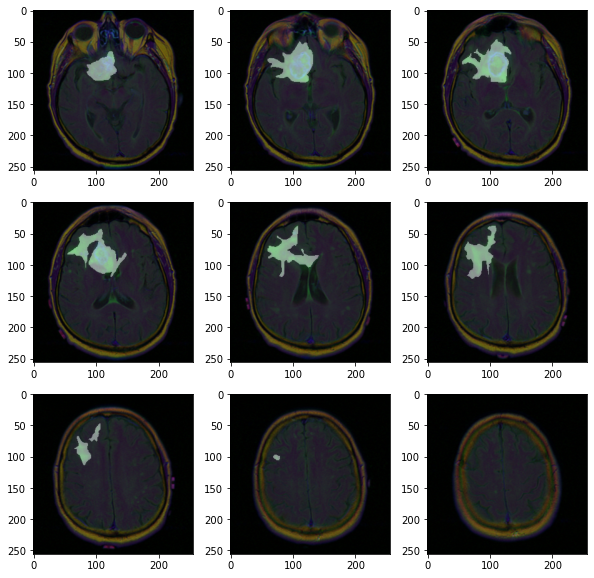

In [3]:
#Lets plot some samples
rows, cols = 3, 3

fig = plt.figure(figsize=(10, 10))

for i in range(1, rows * cols + 1):
    fig.add_subplot(rows, cols, i)
    img_path = train_files[i]
    msk_path = mask_files[i]
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    msk = cv2.imread(msk_path)
    plt.imshow(img)
    plt.imshow(msk, alpha=0.4)
    
plt.show()

In [6]:
def train_generator(data_frame, batch_size, aug_dict,
        image_color_mode = "rgb",
        mask_color_mode = "grayscale",
        image_save_prefix = "image",
        mask_save_prefix = "mask",
        save_to_dir = None,
        target_size = (256, 256),
        seed = 1234):
    '''
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same if you want to visualize the results of generator,
    set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen  = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "filename",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        
        yield (img,mask)

def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)

In [10]:
def dice_coef(y_true, y_pred, smooth=100):
    y_truef = K.flatten(y_true)
    y_predf = K.flatten(y_pred)
    And = K.sum(y_truef * y_predf)

    return((2* And + smooth) / (K.sum(y_truef) + K.sum(y_predf) + smooth))
    
def dice_coef_loss(y_true, y_pred):
    loss = dice_coef(y_true, y_pred)

    return 1 - loss

In [11]:
def unet(input_size=(256,256,3)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(64, (3, 3), padding='same')(inputs)
    bn1   = Activation('relu')(conv1)
    conv1 = Conv2D(64, (3, 3), padding='same')(bn1)
    bn1   = BatchNormalization(axis=3)(conv1)
    bn1   = Activation('relu')(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = Conv2D(128, (3, 3), padding='same')(pool1)
    bn2   = Activation('relu')(conv2)
    conv2 = Conv2D(128, (3, 3), padding='same')(bn2)
    bn2   = BatchNormalization(axis=3)(conv2)
    bn2   = Activation('relu')(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = Conv2D(256, (3, 3), padding='same')(pool2)
    bn3   = Activation('relu')(conv3)
    conv3 = Conv2D(256, (3, 3), padding='same')(bn3)
    bn3   = BatchNormalization(axis=3)(conv3)
    bn3   = Activation('relu')(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

    conv4 = Conv2D(512, (3, 3), padding='same')(pool3)
    bn4   = Activation('relu')(conv4)
    conv4 = Conv2D(512, (3, 3), padding='same')(bn4)
    bn4   = BatchNormalization(axis=3)(conv4)
    bn4   = Activation('relu')(bn4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = Conv2D(1024, (3, 3), padding='same')(pool4)
    bn5   = Activation('relu')(conv5)
    conv5 = Conv2D(1024, (3, 3), padding='same')(bn5)
    bn5   = BatchNormalization(axis=3)(conv5)
    bn5   = Activation('relu')(bn5)

    up6   = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bn5), conv4], axis=3)
    conv6 = Conv2D(512, (3, 3), padding='same')(up6)
    bn6   = Activation('relu')(conv6)
    conv6 = Conv2D(512, (3, 3), padding='same')(bn6)
    bn6   = BatchNormalization(axis=3)(conv6)
    bn6   = Activation('relu')(bn6)

    up7   = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(bn6), conv3], axis=3)
    conv7 = Conv2D(256, (3, 3), padding='same')(up7)
    bn7   = Activation('relu')(conv7)
    conv7 = Conv2D(256, (3, 3), padding='same')(bn7)
    bn7   = BatchNormalization(axis=3)(conv7)
    bn7   = Activation('relu')(bn7)

    up8   = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(bn7), conv2], axis=3)
    conv8 = Conv2D(128, (3, 3), padding='same')(up8)
    bn8   = Activation('relu')(conv8)
    conv8 = Conv2D(128, (3, 3), padding='same')(bn8)
    bn8   = BatchNormalization(axis=3)(conv8)
    bn8   = Activation('relu')(bn8)

    up9   = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(bn8), conv1], axis=3)
    conv9 = Conv2D(64, (3, 3), padding='same')(up9)
    bn9   = Activation('relu')(conv9)
    conv9 = Conv2D(64, (3, 3), padding='same')(bn9)
    bn9   = BatchNormalization(axis=3)(conv9)
    bn9   = Activation('relu')(bn9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(bn9)

    return Model(inputs=[inputs], outputs=[conv10])

In [12]:
df = pd.DataFrame(data={"filename": train_files, 'mask' : mask_files})
df_train, df_test = train_test_split(df, test_size=0.1, random_state=1234)
df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=1234)

In [9]:
EPOCHS = 200
BATCH_SIZE = 64
LEARNING_RATE = 0.0005

train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')

valid_generator_args = dict(rotation_range=0,
                            width_shift_range=0,
                            height_shift_range=0,
                            shear_range=0,
                            zoom_range=0,
                            horizontal_flip=False,
                            fill_mode='nearest')

train_gen = train_generator(df_train, BATCH_SIZE,
                            train_generator_args,
                            target_size=(IM_HEIGHT, IM_WIDTH))
    
valid_gen = train_generator(df_val, BATCH_SIZE,
                            valid_generator_args,
                            target_size=(IM_HEIGHT, IM_WIDTH))
    
model = unet(input_size=(IM_HEIGHT, IM_WIDTH, 3))

optimizer = Adam(lr=LEARNING_RATE)
callbacks = [
    EarlyStopping(patience=20, restore_best_weights=True), 
    ReduceLROnPlateau(patience=10)
]

# model.summary()
model.compile(optimizer=optimizer, 
              loss=dice_coef_loss, 
              metrics=["binary_accuracy", tf.keras.metrics.MeanIoU(num_classes=2), dice_coef])

history = model.fit(train_gen,
                    steps_per_epoch=len(df_train) / BATCH_SIZE, 
                    epochs=EPOCHS, 
                    callbacks=callbacks,
                    validation_data=valid_gen,
                    validation_steps=len(df_val) / BATCH_SIZE,
                    verbose=2)

model.save('weights/unet_best_keras')

Found 2828 validated image filenames.
Found 2828 validated image filenames.
Epoch 1/200
Found 708 validated image filenames.
Found 708 validated image filenames.
44/44 - 66s - loss: 0.8794 - binary_accuracy: 0.9222 - mean_io_u_1: 0.6333 - dice_coef: 0.1223 - val_loss: 0.9761 - val_binary_accuracy: 0.9915 - val_mean_io_u_1: 0.4957 - val_dice_coef: 0.0225
Epoch 2/200
44/44 - 63s - loss: 0.7765 - binary_accuracy: 0.9821 - mean_io_u_1: 0.6791 - dice_coef: 0.2258 - val_loss: 0.9784 - val_binary_accuracy: 0.9907 - val_mean_io_u_1: 0.4954 - val_dice_coef: 0.0201
Epoch 3/200
44/44 - 63s - loss: 0.6539 - binary_accuracy: 0.9892 - mean_io_u_1: 0.6974 - dice_coef: 0.3487 - val_loss: 0.9806 - val_binary_accuracy: 0.0102 - val_mean_io_u_1: 0.0063 - val_dice_coef: 0.0200
Epoch 4/200
44/44 - 63s - loss: 0.5095 - binary_accuracy: 0.9925 - mean_io_u_1: 0.7264 - dice_coef: 0.4908 - val_loss: 0.9804 - val_binary_accuracy: 0.0921 - val_mean_io_u_1: 0.0740 - val_dice_coef: 0.0181
Epoch 5/200
44/44 - 63s - 

Epoch 40/200
44/44 - 62s - loss: 0.1985 - binary_accuracy: 0.9961 - mean_io_u_1: 0.8231 - dice_coef: 0.8031 - val_loss: 0.4252 - val_binary_accuracy: 0.9881 - val_mean_io_u_1: 0.7746 - val_dice_coef: 0.5787
Epoch 41/200
44/44 - 61s - loss: 0.1685 - binary_accuracy: 0.9966 - mean_io_u_1: 0.8426 - dice_coef: 0.8319 - val_loss: 0.2202 - val_binary_accuracy: 0.9961 - val_mean_io_u_1: 0.8188 - val_dice_coef: 0.7793
Epoch 42/200
Epoch 44/200
44/44 - 61s - loss: 0.1567 - binary_accuracy: 0.9968 - mean_io_u_1: 0.8479 - dice_coef: 0.8443 - val_loss: 0.1568 - val_binary_accuracy: 0.9973 - val_mean_io_u_1: 0.8496 - val_dice_coef: 0.8501
Epoch 45/200
44/44 - 61s - loss: 0.1591 - binary_accuracy: 0.9967 - mean_io_u_1: 0.8486 - dice_coef: 0.8420 - val_loss: 0.1569 - val_binary_accuracy: 0.9974 - val_mean_io_u_1: 0.8259 - val_dice_coef: 0.8476
Epoch 46/200
44/44 - 61s - loss: 0.1486 - binary_accuracy: 0.9970 - mean_io_u_1: 0.8555 - dice_coef: 0.8516 - val_loss: 0.1971 - val_binary_accuracy: 0.9969 - 

Epoch 82/200
44/44 - 62s - loss: 0.1228 - binary_accuracy: 0.9975 - mean_io_u_1: 0.8745 - dice_coef: 0.8766 - val_loss: 0.1188 - val_binary_accuracy: 0.9980 - val_mean_io_u_1: 0.8713 - val_dice_coef: 0.8889
Epoch 83/200
44/44 - 62s - loss: 0.1254 - binary_accuracy: 0.9975 - mean_io_u_1: 0.8729 - dice_coef: 0.8750 - val_loss: 0.1357 - val_binary_accuracy: 0.9977 - val_mean_io_u_1: 0.8514 - val_dice_coef: 0.8663
Epoch 84/200
44/44 - 61s - loss: 0.1244 - binary_accuracy: 0.9974 - mean_io_u_1: 0.8714 - dice_coef: 0.8754 - val_loss: 0.1221 - val_binary_accuracy: 0.9978 - val_mean_io_u_1: 0.8681 - val_dice_coef: 0.8550
Epoch 85/200
44/44 - 62s - loss: 0.1210 - binary_accuracy: 0.9975 - mean_io_u_1: 0.8731 - dice_coef: 0.8777 - val_loss: 0.1236 - val_binary_accuracy: 0.9978 - val_mean_io_u_1: 0.8650 - val_dice_coef: 0.8779
Epoch 86/200
44/44 - 60s - loss: 0.1265 - binary_accuracy: 0.9974 - mean_io_u_1: 0.8722 - dice_coef: 0.8746 - val_loss: 0.1288 - val_binary_accuracy: 0.9978 - val_mean_io_u

In [13]:
# del model
model = tf.keras.models.load_model('weights/unet_best_keras', 
                                   custom_objects={'dice_coef_loss' : dice_coef_loss, 'dice_coef' : dice_coef})
LEARNING_RATE = 0.0005
optimizer = Adam(lr=LEARNING_RATE)

model.compile(optimizer=optimizer, 
              loss=dice_coef_loss, 
              metrics=["binary_accuracy", tf.keras.metrics.MeanIoU(num_classes=2), dice_coef])

NameError: name 'tf' is not defined

In [16]:
test_gen = train_generator(df_test, BATCH_SIZE,
                           valid_generator_args,
                           target_size=(IM_HEIGHT, IM_WIDTH))

results = model.evaluate(test_gen, steps=len(df_test) / BATCH_SIZE)

print("")
print("Test lost: ", round(results[0], 4))
print("Test Accuracy: ", round(results[1], 4))
print("Test IOU: ", round(results[2], 4))
print("Test Dice Coefficent: ", round(results[3], 4))

Found 393 validated image filenames.
Found 393 validated image filenames.
6/6 [==============================] - 2s 299ms/step - loss: 0.1311 - binary_accuracy: 0.9976 - mean_io_u_2: 0.8649 - dice_coef: 0.8763

Test lost:  0.1311
Test Accuracy:  0.9976
Test IOU:  0.8649
Test Dice Coefficent:  0.8763


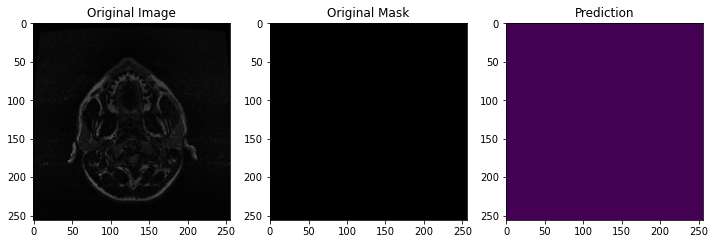

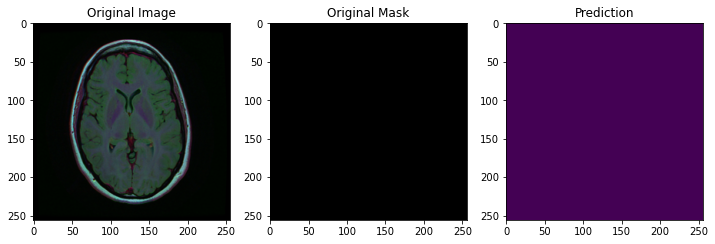

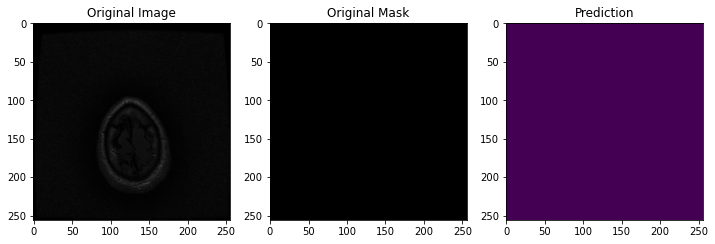

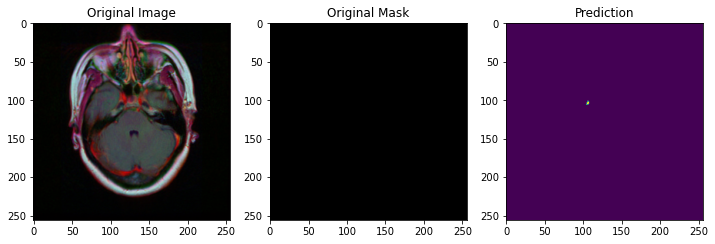

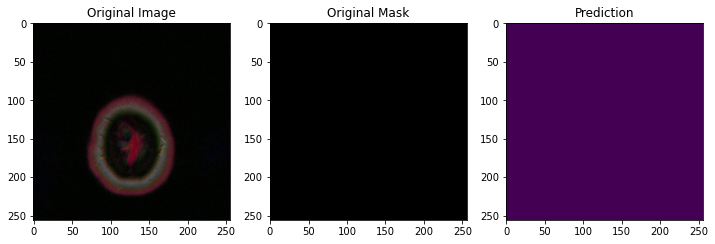

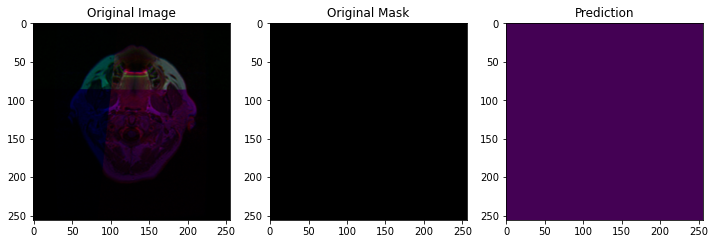

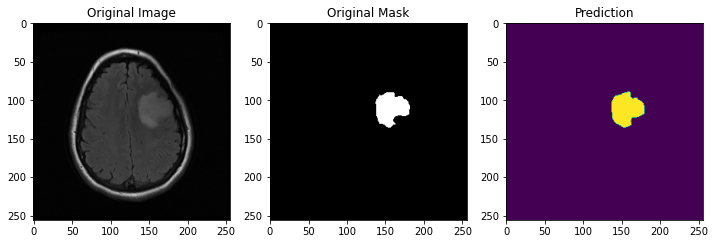

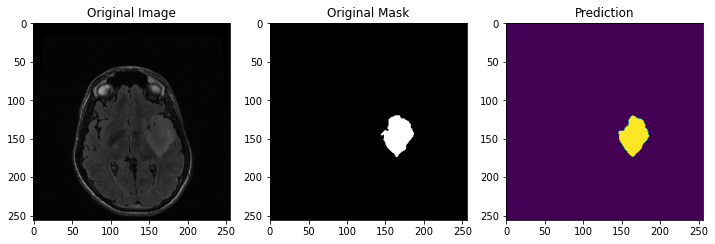

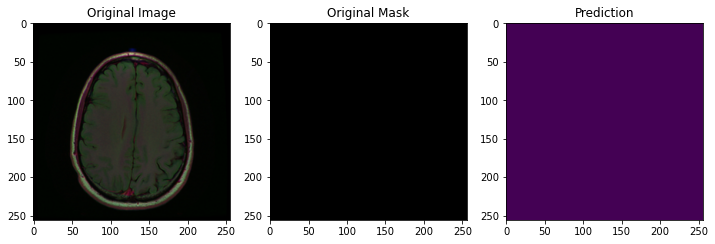

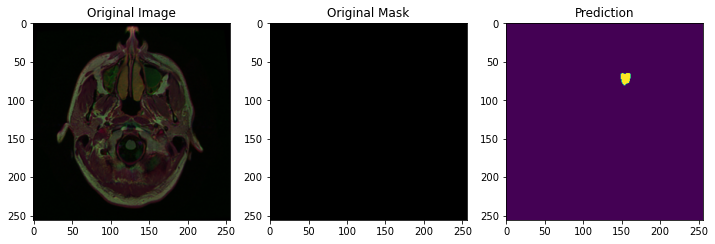

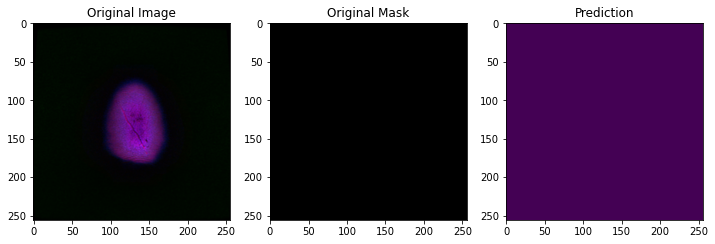

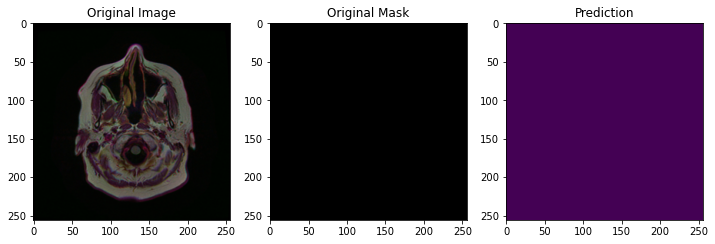

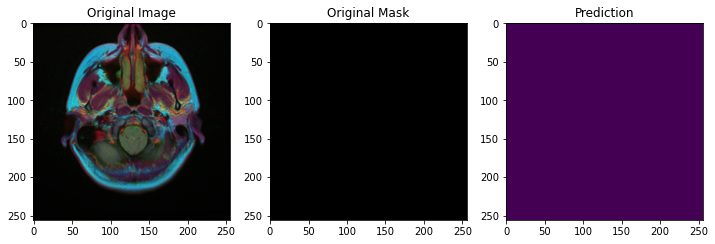

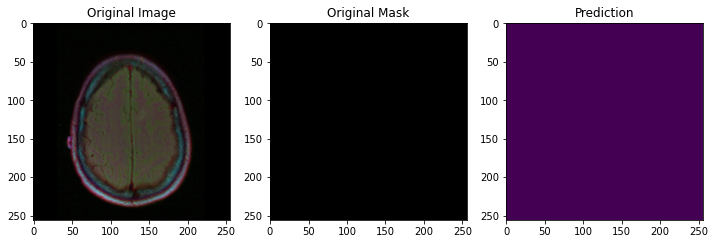

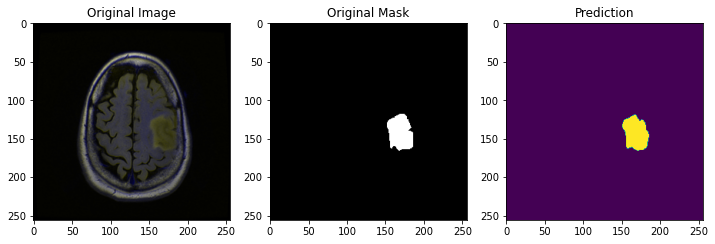

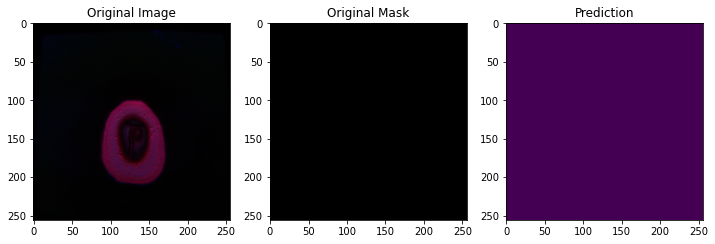

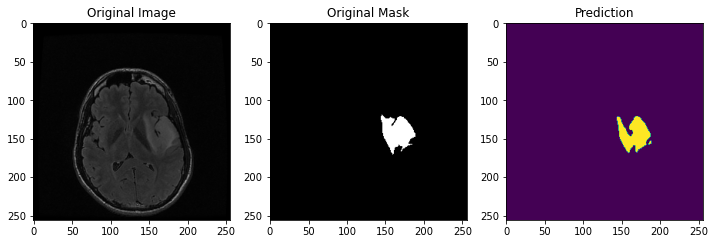

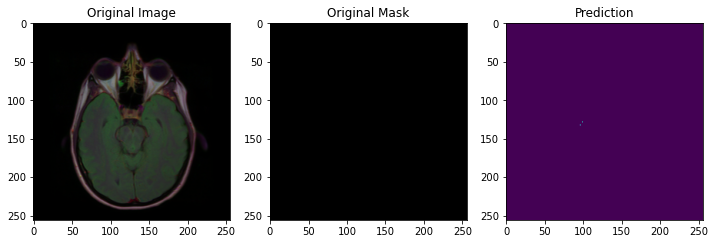

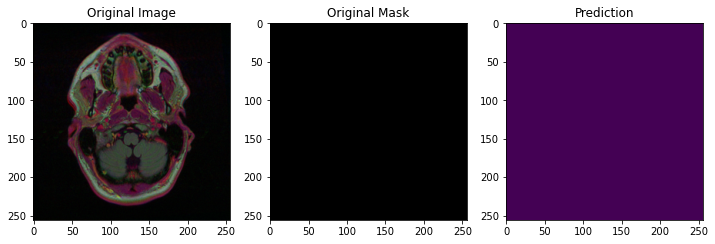

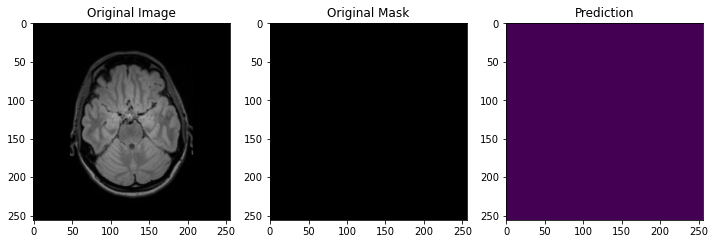

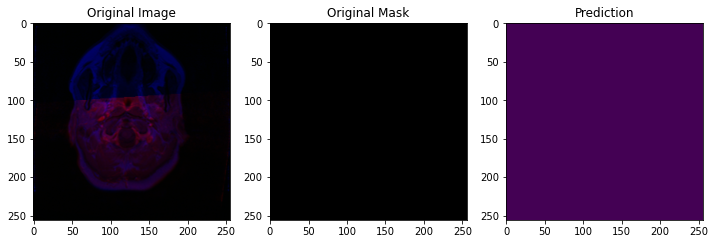

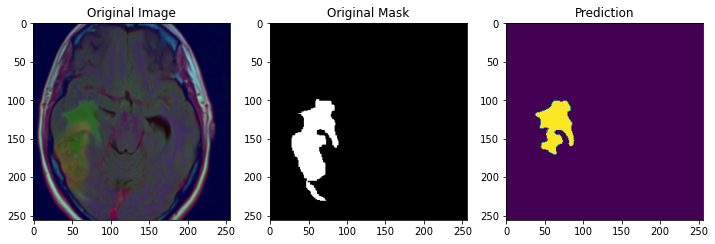

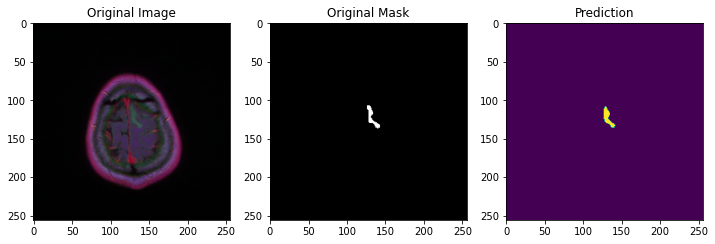

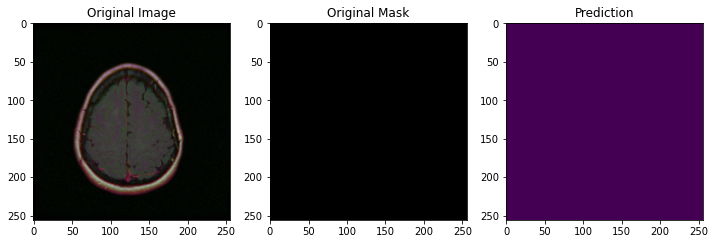

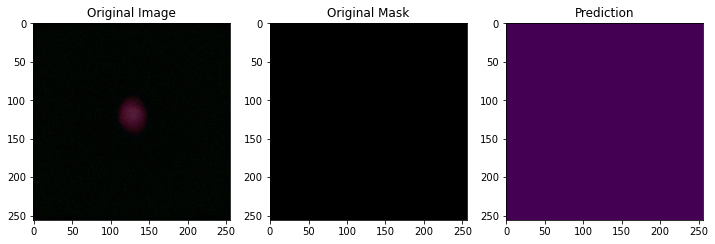

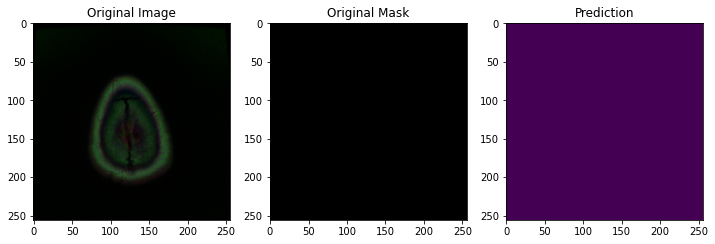

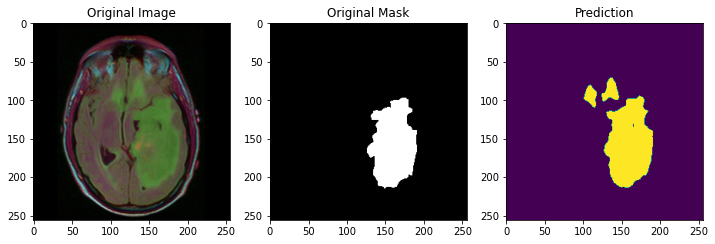

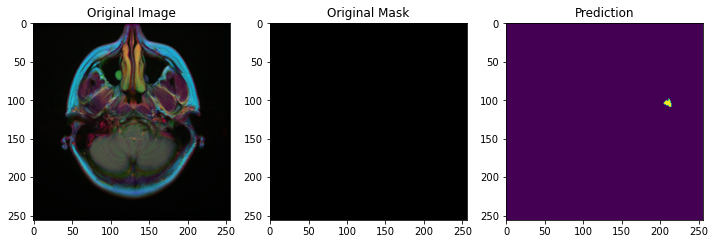

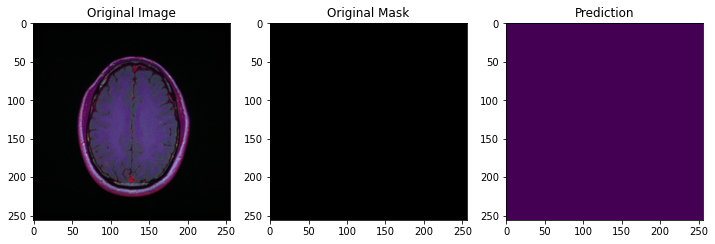

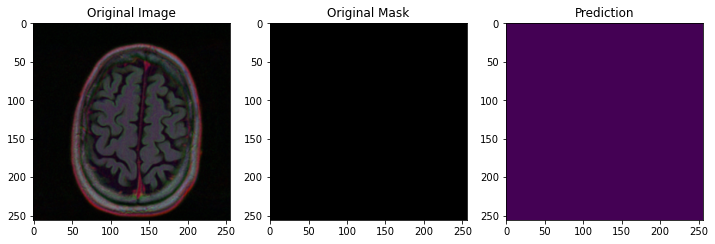

In [17]:
for i in range(30):
    
    index = np.random.randint(1, len(df_test.index))
    img   = cv2.imread(df_test['filename'].iloc[index])
    img   = cv2.resize(img ,(IM_HEIGHT, IM_WIDTH))
    img   = img / 255
    img   = img[np.newaxis, :, :, :]
    pred  = model.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask'].iloc[index])))
    plt.title('Original Mask')
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(pred) > .5)
    plt.title('Prediction')
    plt.show()